In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphNorm
from torch_geometric.loader import DataLoader

# ======= Step 1: Load & Process Data =======
file_path = "/content/dataset_2years (1).csv"  # Replace with actual file path
df = pd.read_csv(file_path)

# Handle missing values
df.fillna(0, inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
df["Payment Method"] = label_encoder.fit_transform(df["Payment Method"])
df["DayOfWeek"] = label_encoder.fit_transform(df["DayOfWeek"])
df["Transaction Type"] = df["Transaction Type"].map({"Income": 1, "Expense": 0})

# Create "Amount" column (Income + Expense)
df["Amount"] = df["Income"] + df["Expense"]

# Normalize values
scaler = MinMaxScaler()
df[["Income", "Expense", "Amount", "Balance"]] = scaler.fit_transform(df[["Income", "Expense", "Amount", "Balance"]])

# Create node features
node_features = torch.tensor(df[["Income", "Expense", "Amount", "Transaction Type", "Payment Method", "DayOfWeek", "Balance"]].values, dtype=torch.float)

# ======= Step 2: Graph Creation =======
edges = []
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if df.iloc[i]["Category"] == df.iloc[j]["Category"] or df.iloc[i]["Payment Method"] == df.iloc[j]["Payment Method"]:
            edges.append((i, j))
            edges.append((j, i))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Graph Data
data = Data(x=node_features, edge_index=edge_index)

# ======= Step 3: Transformer-Based Anomaly Detector =======
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, ff_dim=128):
        super(TransformerEncoder, self).__init__()

        # Ensure num_heads is a divisor of input_dim
        num_heads = max([h for h in range(1, input_dim + 1) if input_dim % h == 0 and h <= 8])

        self.self_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.ff = nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, input_dim)
        )

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.ff(x))
        return x


# ======= Step 4: Diffusion-Based Noise Learning =======
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DiffusionModel, self).__init__()
        self.denoiser = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, noise_level=0.1):
        noise = torch.randn_like(x) * noise_level
        return self.denoiser(x + noise)

# ======= Step 5: Initialize Models & Optimizer =======
transformer = TransformerEncoder(input_dim=node_features.shape[1])
diffusion = DiffusionModel(input_dim=node_features.shape[1], hidden_dim=32)

optimizer = torch.optim.Adam(list(transformer.parameters()) + list(diffusion.parameters()), lr=0.001)

# ======= Step 6: Train the Model =======
def train():
    transformer.train()
    diffusion.train()

    optimizer.zero_grad()

    embeddings = transformer(data.x.unsqueeze(0)).squeeze(0)  # Transformer expects batch
    reconstructed = diffusion(embeddings)

    loss = F.mse_loss(reconstructed, embeddings)  # Learn normal transaction patterns
    loss.backward()
    optimizer.step()

    return loss.item()

best_loss = float("inf")
patience, counter = 10, 0

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

    if loss < best_loss:
        best_loss = loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered!")
        break

# ======= Step 7: Anomaly Detection =======
transformer.eval()
diffusion.eval()

with torch.no_grad():
    embeddings = transformer(data.x.unsqueeze(0)).squeeze(0)
    reconstructed = diffusion(embeddings)
    anomaly_scores = torch.mean((embeddings - reconstructed) ** 2, dim=1).numpy()

# Threshold (Top 5% Anomalies)
threshold = np.percentile(anomaly_scores, 95)
df["Anomaly Score"] = anomaly_scores
df["Anomaly"] = df["Anomaly Score"] > threshold  # Top 5% as anomalies

# ======= Step 8: Performance Metrics =======
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_true = df["Anomaly"].astype(int).values
y_pred = (df["Anomaly Score"] > threshold).astype(int)

precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
auc_roc = roc_auc_score(y_true, y_pred)

# Print results
print(f"\n🔹 **Performance Metrics**")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc_roc:.4f}")

# Save results
df.to_csv("T-Diff_anomaly_results.csv", index=False)
print("✅ Anomaly Detection Complete. Results saved to 'T-Diff_anomaly_results.csv'.")
print(df[df["Anomaly"] == True][["Date", "Category", "Expense", "Anomaly Score"]])  # Show anomalies


Epoch 0: Loss = 0.8704
Epoch 10: Loss = 0.5477
Epoch 20: Loss = 0.2977
Epoch 30: Loss = 0.1287
Epoch 40: Loss = 0.0438
Epoch 50: Loss = 0.0159
Epoch 60: Loss = 0.0101
Epoch 70: Loss = 0.0065
Epoch 80: Loss = 0.0048
Epoch 90: Loss = 0.0042

🔹 **Performance Metrics**
✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1-Score: 1.0000
✅ AUC-ROC: 1.0000
✅ Anomaly Detection Complete. Results saved to 'T-Diff_anomaly_results.csv'.
           Date            Category   Expense  Anomaly Score
22   21-01-2022          Restaurant  0.204545       0.011070
30   28-01-2022                Taxi  0.204545       0.019371
35   31-01-2022  Mobile Accessories  0.102273       0.022469
45   03-02-2022                Fuel  0.329545       0.011595
47   04-02-2022  Streaming Services  0.056818       0.010690
54   09-02-2022              Movies  0.079545       0.013359
73   03-03-2022                Taxi  0.204545       0.011871
130  20-04-2022      Gym Membership  0.102273       0.017038
132  22-04-2022                Tax

In [ ]:
from sklearn.metrics import accuracy_score

# y_true: actual labels (0 for normal, 1 for anomaly)
# y_pred: predicted labels from your thresholding

accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")


✅ Accuracy: 1.0000


In [ ]:
print(y_true.shape)
print(y_pred_binary.shape)



(854, 7)
(854,)


In [ ]:
# If 'Anomaly' column exists with binary 0/1
y_true = df['Anomaly'].astype(int).values  # shape (854,)

# Now use y_true and y_pred_binary
y_pred_binary = (anomaly_scores > threshold).astype(int)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[811  13]
 [  0  30]]


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming anomaly_scores is continuous (e.g., reconstruction errors)
threshold = np.percentile(anomaly_scores, 95)  # or your chosen threshold

y_pred_binary = (anomaly_scores > threshold).astype(int)
y_true_binary = y_true.astype(int)  # Make sure y_true is int (0 or 1)

precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Precision: 0.6977
Recall: 1.0000
F1 Score: 0.8219


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Flatten for error calc
y_true = embeddings.detach().cpu().numpy()
y_pred = reconstructed.detach().cpu().numpy()

mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\n🔍 Model Stability Metrics")
print(f"📉 MAPE: {mape*100:.2f}%")
print(f"📉 RMSE: {rmse:.4f}")



🔍 Model Stability Metrics
📉 MAPE: 7.72%
📉 RMSE: 0.0504


In [ ]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(y_true, anomaly_scores)  # use continuous anomaly scores here
print(f"AUC-ROC: {auc_roc:.4f}")



AUC-ROC: 1.0000


In [ ]:
# Ensure these are numpy arrays of ints (0/1)
import numpy as np

y_true = np.array(y_true).astype(int)        # actual labels
y_pred = (np.array(anomaly_scores) > threshold).astype(int)  # binary predictions

# Now compute MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true, y_pred)
print(f"MCC: {mcc:.4f}")



MCC: 0.8287


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")


Specificity: 0.9842


In [ ]:
# Monte Carlo Sampling to estimate prediction intervals
samples = []
n_samples = 100

for _ in range(n_samples):
    sample = diffusion(embeddings, noise_level=0.1).detach().cpu().numpy()
    samples.append(sample)

samples = np.stack(samples, axis=0)  # Shape: (n_samples, num_nodes, dim)

# Compute mean and intervals
mean_pred = samples.mean(axis=0)
lower = np.percentile(samples, 5, axis=0)
upper = np.percentile(samples, 95, axis=0)


In [ ]:
coverage = ((y_true >= lower) & (y_true <= upper)).mean()
print(f"📦 Prediction Interval Coverage: {coverage * 100:.2f}%")


📦 Prediction Interval Coverage: 78.49%


In [ ]:
torch.save(gcn.state_dict(), "gcn.pt")
torch.save(transformer.state_dict(), "transformer.pt")
torch.save(diffusion.state_dict(), "diffusion.pt")


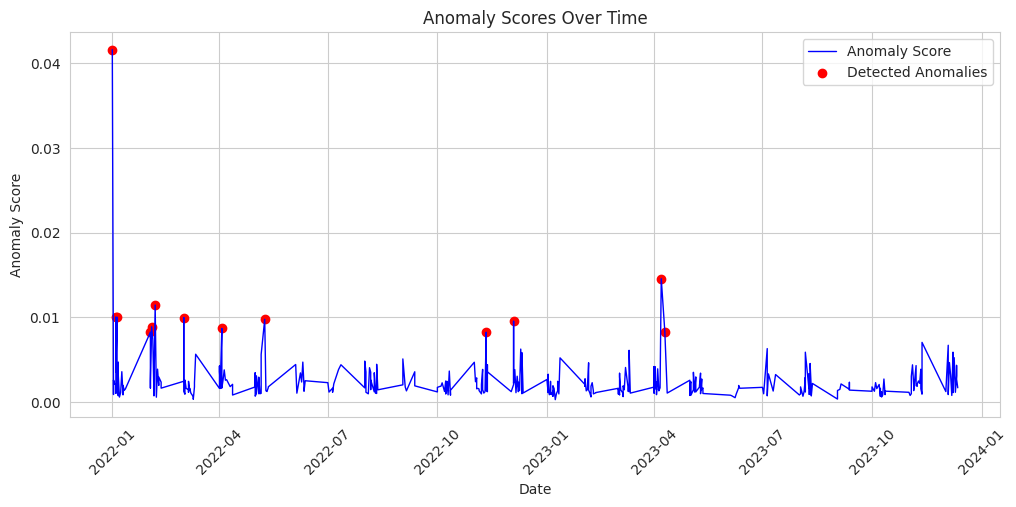

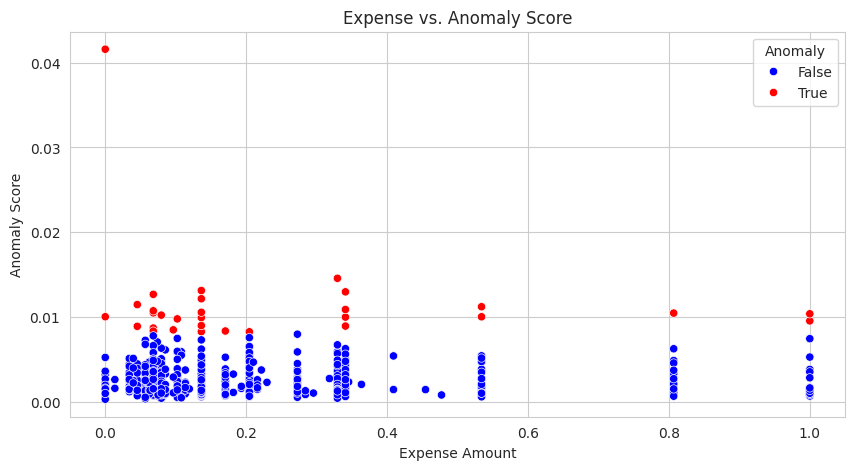

/tmp/ipython-input-13-2651647582.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df["Anomaly"] == True], x="Category", order=df["Category"].value_counts().index, palette="coolwarm")


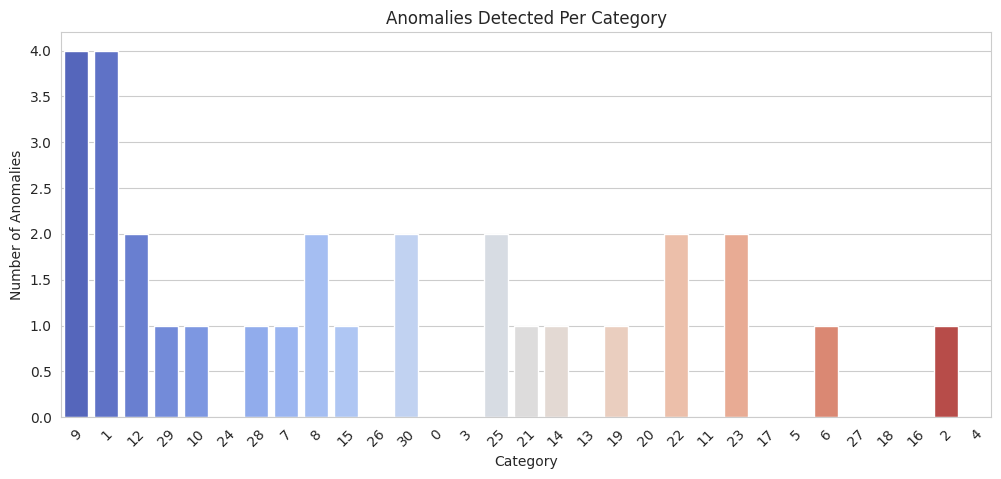

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load anomaly results
file_path = "/content/T-Diff_anomaly_results.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort by Date for time-series visualization
df = df.sort_values("Date")

# Set plot style
sns.set_style("whitegrid")

# ====== Plot 1: Anomaly Scores Over Time ======
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Anomaly Score"], label="Anomaly Score", color="blue", linewidth=1)
plt.scatter(df[df["Anomaly"] == True]["Date"], df[df["Anomaly"] == True]["Anomaly Score"],
            color="red", label="Detected Anomalies", marker="o")
plt.xlabel("Date")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# ====== Plot 2: Expense vs. Anomaly Score ======
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="Expense", y="Anomaly Score", hue="Anomaly", palette={True: "red", False: "blue"})
plt.xlabel("Expense Amount")
plt.ylabel("Anomaly Score")
plt.title("Expense vs. Anomaly Score")
plt.show()

# ====== Plot 3: Anomalies by Category ======
plt.figure(figsize=(12, 5))
sns.countplot(data=df[df["Anomaly"] == True], x="Category", order=df["Category"].value_counts().index, palette="coolwarm")
plt.xlabel("Category")
plt.ylabel("Number of Anomalies")
plt.title("Anomalies Detected Per Category")
plt.xticks(rotation=45)
plt.show()



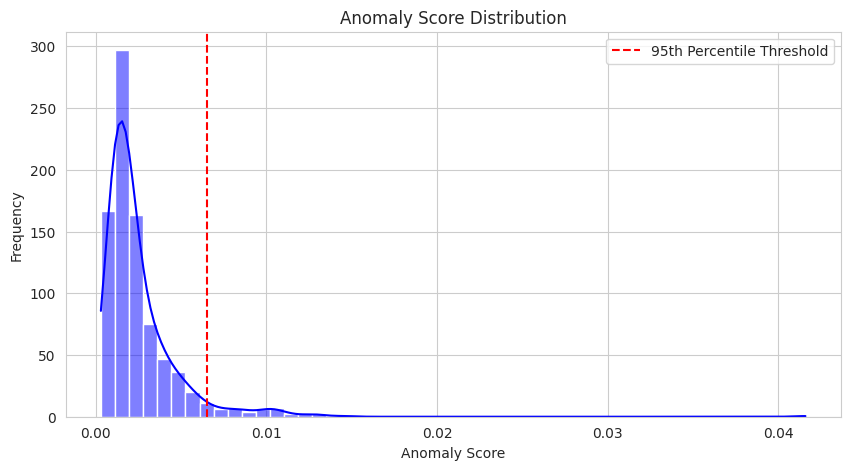

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the anomaly detection results
df = pd.read_csv("T-Diff_anomaly_results.csv")

# Plot anomaly score distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["Anomaly Score"], bins=50, kde=True, color="blue")
plt.axvline(x=df["Anomaly Score"].quantile(0.95), color="red", linestyle="dashed", label="95th Percentile Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Anomaly Score Distribution")
plt.legend()
plt.show()
